# Kernel Regression

Given a training dataset $\{x_i, y_i\}_{i=1}^n$, kernel regression approximates the unknown 
nolinear relation between $x$ and $y$ with a function of form
$$
y\approx f(x;w) = \sum_{i=1}^n w_i k(x, x_i),
$$
where $k(x, x')$ is a positive definite kernel specified by the users, and ${w_i}$ is a
set of weights. 
We will use the simple Gaussian radius basis funciton (RBF) kernel,
$$
k(x, x') = exp(-\frac{||x-x'||^2}{2h^2}),
$$
where $h$ is a bandwith parameter. 


### Step 1. Simulate a 1-dimensional dataset

xTrain shape (100, 1) yTrain shape (100, 1)


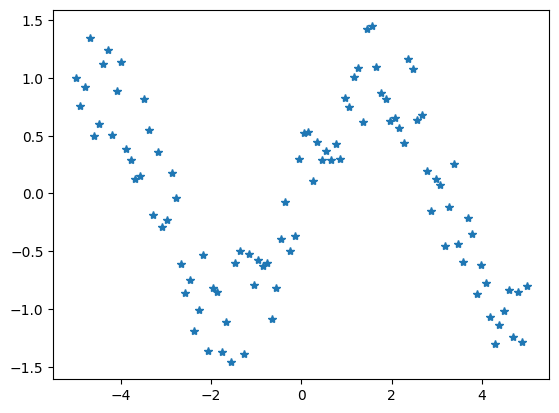

In [2]:

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(100)

### Step 1: Simulate a simple 1D data ###
xTrain = np.expand_dims(np.linspace(-5, 5, 100), 1)  # 100*1
yTrain = np.sin(xTrain) + 0.5*np.random.uniform(-1, 1, size=xTrain.shape) ## 100 *1

print('xTrain shape', xTrain.shape, 'yTrain shape', yTrain.shape)
plt.plot(xTrain, yTrain, '*')
plt.show()

Now we have a dataset with 100 training data points. Let us calculate the kernel function. 

### Step 2. Kernel function

Your task is to complete the following rbf_kernel function that takes two sets of points $X$ (of size $n$) and $X'$ (of size $m$) and the bandwidth $h$ and ouputs their pairwise  kernel matrix $K = [k(x_i, x_j)]_{ij}$, which is of size $n\times m$. We will represent input data as matrices, with $X=[x_i]_{i=1}^n \in R^{n\times 1}$ denoting the input features and $Y=[y_i]_{i=1}^n\in R^{n\times 1}$ the input labels.)

In [3]:
"""
    calcuating kernel matrix between X and Xp
"""
def rbf_kernel(X, Xp, h):
    # X: n*1 matrix
    # Xp: m*1 matrix
    # h: scalar value 
    
    # Calculate pairwise squared distances
    X_expanded = np.expand_dims(X, axis=1)  # Shape: (n, 1, 1)
    Xp_expanded = np.expand_dims(Xp, axis=0)  # Shape: (1, m, 1)
    squared_distances = np.sum((X_expanded - Xp_expanded) ** 2, axis=2)  # Shape: (n, m)
    
    # Apply RBF formula: exp(-||x-x'||^2 / (2h^2))
    K = np.exp(-squared_distances / (2 * h**2))
    
    return K  # n*m matrix



### evaluation: if your implementation is correct, you should expect the output is a 2X3 matrix
# [[0.60653066 1.         0.60653066]
# [0.13533528 0.60653066 1.        ]]
k_test = rbf_kernel(np.array([[2],[1]]), np.array([[3],[2],[1]]), 1)
print(k_test)
    

[[0.60653066 1.         0.60653066]
 [0.13533528 0.60653066 1.        ]]


### Step 3. The median trick for bandwith
The choice of the bandwidth $h$
A common way to set the bandwith $h$ in practice is the so called median trick,
which sets $h$ to be the median of the pairwise distance on the training data, that is
$$
h_{med} = median(\{||x_i - x_j||: i\neq j, ~~~~~~i,j =1, ..., n\}).
$$

- Task: Compelete the median distance function. 


In [9]:
from scipy.spatial import distance

def median_distance(X):
    # X: n*1 matrix
    
    # Calculate pairwise distances
    dist = distance.cdist(X, X)
    
    # Get all pairwise distances excluding self-distances (diagonal)
    distances = [dist[i, j] for i in range(len(X)) for j in range(len(X)) if i != j]
    
    # Calculate median
    h = np.median(distances)
    
    return h


### Test your functions
#evaluation: if your implementation is correct, your answer should be [2.0]
h_test = median_distance(np.array([[1],[2],[4]]))
print(h_test)

2.0


### Step 4. Kernel regression
The weights ${w_i}$ are estimated by minimizing a regularized mean square error:
$$
\min_w {\left ( \sum_{i=1}^n (y_i - f(x_i; w))^2 \right) + \beta w^\top K w },     
$$
where $w$ is the column vector formed by $w=[w_i]_{i=1}^n$ and K is the kernel matrix.

- Please derive the optimal solution of $w$ using matrix inverseion (no need to show the work) 

- Complete the following function to implement the calculation of $w$ 

In [10]:
def kernel_regression_fitting(xTrain, yTrain, h, beta=1):
    # X: input data, numpy array, n*1
    # Y: input labels, numpy array, n*1
    
    # Calculate kernel matrix K
    K = rbf_kernel(xTrain, xTrain, h)
    
    # Add regularization term (beta * I)
    n = len(xTrain)
    K_reg = K + beta * np.eye(n)
    
    # Solve for weights: W = (K + βI)^(-1)y
    W = np.linalg.solve(K_reg, yTrain)
    
    # Ensure output shape is (n, 1)
    W = W.reshape(-1, 1)
    
    return W

### evaluating your code, the shape should be (100, 1) (check the values yourself)
h = median_distance(xTrain)
W_test = kernel_regression_fitting(xTrain, yTrain, h)
print(W_test.shape)

(100, 1)


### Step 5. Evaluation and Cross Validation

We now need to evaluate the algorithm on the testing data and select the hyperparameters (bandwidth and regularization coefficient) using cross validation

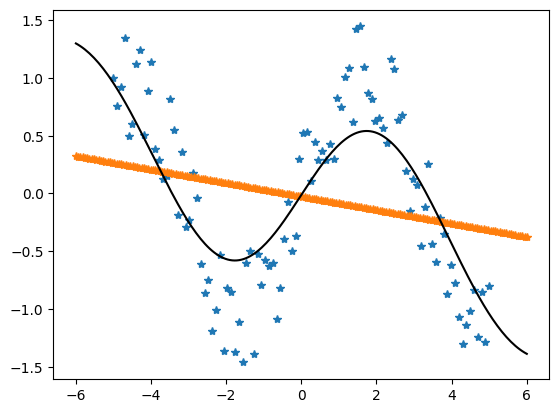

In [11]:
# Please run and read the following base code 

def kernel_regression_fit_and_predict(xTrain, yTrain, xTest, h, beta):
    
    #fitting on the training data 
    W = kernel_regression_fitting(xTrain, yTrain, h, beta)
    
    # computing the kernel matrix between xTrain and xTest
    K_xTrain_xTest = rbf_kernel(xTrain, xTest, h)
   
    # predict the label of xTest
    yPred = np.dot( K_xTrain_xTest.T, W)
    return yPred

# generate random testing data
xTest = np.expand_dims(np.linspace(-6, 6, 200), 1) ## 200*1


beta = 1.
# calculating bandwith
h_med = median_distance(xTrain)  
yHatk = kernel_regression_fit_and_predict(xTrain, yTrain, xTest, h_med, beta)


# we also add linear regression for comparision
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(xTrain, yTrain)  
yHat = lr.predict(xTest) # prediction

# visulization
plt.plot(xTrain, yTrain, '*')
plt.plot(xTest, yHat, '*')
plt.plot(xTest, yHatk, '-k')
plt.show()

### Step 5.1. Impact of bandwith 
Run the kernel regression with regularization coefficient $\beta=1$ and 
bandwidth $h \in \{ 0.1 h_{med}, h_{med}, 10h_{med}\}$.

- Task: Show the curve learned by different $h$. Comment on how $h$ influences the smoothness of $h$.


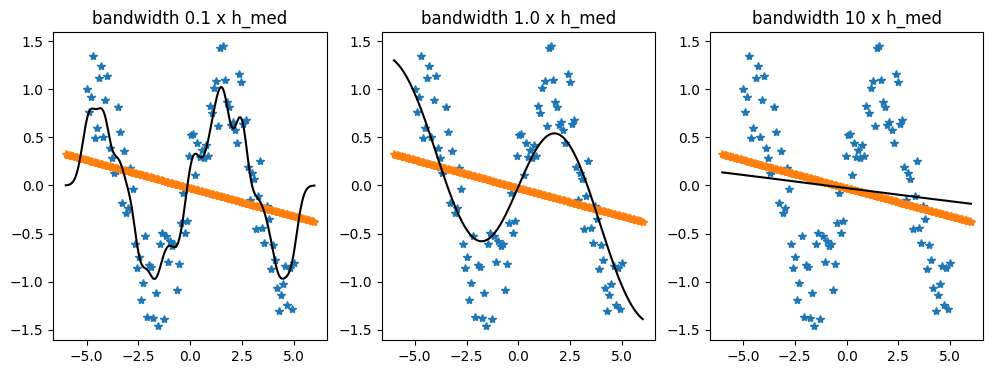

In [12]:
### fitting on the training data ###
beta = 1.

plt.figure(figsize=(12, 4))
for i, coff in enumerate([0.1, 1., 10]):
    plt.subplot(1, 3, i+1)
    
    # Calculate bandwidth and run kernel regression
    h = coff * h_med
    yHatk_i = kernel_regression_fit_and_predict(xTrain, yTrain, xTest, h, beta)
    
    # visualization
    plt.plot(xTrain, yTrain, '*')
    plt.plot(xTest, yHat, '*')
    plt.plot(xTest, yHatk_i, '-k')
    plt.title('bandwidth {} x h_med'.format(coff))
    
plt.show()


# Comment on Impact of Bandwidth Parameter on Curve Smoothness

Based on the plots, we can observe how the bandwidth parameter h significantly influences the smoothness of the kernel regression curve:

- **Small bandwidth (0.1 × h_med)**: The curve is very wiggly and follows the training points closely. This indicates high flexibility but risks overfitting to noise in the training data.

- **Medium bandwidth (1.0 × h_med)**: The curve achieves a good balance between smoothness and data fitting. It captures the underlying sinusoidal pattern while smoothing out some of the noise.

- **Large bandwidth (10 × h_med)**: The curve becomes extremely smooth, almost linear. This indicates severe underfitting as the model loses its ability to capture the nonlinear patterns in the data. The curve approaches the linear regression solution (orange line).

This demonstrates that h acts as a smoothing parameter - smaller values lead to more flexible, potentially overfit models, while larger values create smoother, potentially underfit models. Choosing an appropriate h is crucial for balancing bias and variance in the model.

### Step 5.2. Cross Validation (CV)
Use 5-fold cross validation to find the optimal combination of 
$h$ and $\beta$ within $h\in \{0.1h_{med}, h_{med}, 10h_{med}\}$ and $\beta \in \{0.1, 1\}$.
- Task: complete the code of cross validation and find the best $h$ and $\beta$. Plot the curve fit with the optimal hyperparameters.

Beta beta 1 Best bandwith 0.1*h_med mse 0.11166229355896191


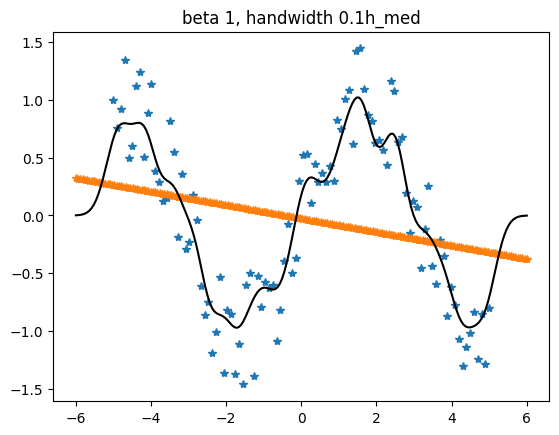

In [14]:
best_beta, best_coff = 1., 1.
best_mse = 1e8
for beta in [0.1, 1]:
    for coff in [0.1, 1., 10.]:
        # 5-fold cross validation
        max_fold = 5
        mse = []
        for i in range(max_fold):
            # Calculate indices for train/test split
            all_indices = np.arange(len(xTrain))
            testIdx = all_indices[all_indices % max_fold == i]
            trnIdx = all_indices[all_indices % max_fold != i]
            
            i_xTrain, i_yTrain = xTrain[trnIdx], yTrain[trnIdx]
            i_xValid, i_yValid = xTrain[testIdx], yTrain[testIdx]
            
            # Calculate bandwidth and make predictions
            h = coff * median_distance(i_xTrain)
            i_yPred = kernel_regression_fit_and_predict(i_xTrain, i_yTrain, i_xValid, h, beta)
            
            # Calculate MSE for this fold
            mse.append(np.mean((i_yValid - i_yPred)**2))
            
        mse = np.mean(mse)
        
        # keep track of the combination with the best MSE
        if mse < best_mse:
            best_beta, best_coff = beta, coff
            best_mse = mse
        
print('Beta beta', best_beta, 'Best bandwith', '{}*h_med'.format(best_coff), 'mse', best_mse)

# bandwith
h = best_coff * median_distance(xTrain)  
yHatk_i = kernel_regression_fit_and_predict(xTrain, yTrain, xTest, h, best_beta)
    
# visulization
plt.plot(xTrain, yTrain, '*')
plt.plot(xTest, yHat, '*')
plt.plot(xTest, yHatk_i, '-k')
plt.title('beta {}, handwidth {}h_med'.format(best_beta, best_coff))
plt.show()